# Fractal VR TMT analysis. (in R)


This notebook is running behavioral analysis of Fractal VR data. 


Only needed to be done once:

In [ ]:
packages <- c(
  "ez", "emmeans", "cowplot", "dplyr", "readr", "ggplot2", "lmerTest", 
  "hrbrthemes", "sjPlot", "sjmisc", "sjlabelled", "tidyr", "tidyverse", 
  "ggthemes", "ggpubr", "knitr", "jtools", "apaTables", "psych", "boot"
)

install.packages(packages)

In [1]:
# load libraries
library(ez)
citation("ez")
library(emmeans)
citation("emmeans")

# Plotting and formatting
library(cowplot)
library(dplyr)
library(readr) 
library(ggplot2)
#library(lmerTest)
library(hrbrthemes)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
# Raincloud plot( from https://github.com/RainCloudPlots/RainCloudPlots):
# this file needs to be in the same directory as the script
source('R_rainclouds.R')
library(tidyr)
library(tidyverse)
library(ggthemes)
library(ggpubr)
# Formatting
library(knitr)
library(jtools)
library(apaTables)
# Reliability
library(psych)
library(tidyr)
library(boot)


To cite package ‘ez’ in publications use:

  Lawrence MA (2016). _ez: Easy Analysis and Visualization of Factorial
  Experiments_. R package version 4.4-0,
  <https://CRAN.R-project.org/package=ez>.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {ez: Easy Analysis and Visualization of Factorial Experiments},
    author = {Michael A. Lawrence},
    year = {2016},
    note = {R package version 4.4-0},
    url = {https://CRAN.R-project.org/package=ez},
  }

ATTENTION: This citation information has been auto-generated from the
package DESCRIPTION file and may need manual editing, see
‘help("citation")’.

To cite package ‘emmeans’ in publications use:

  Lenth R (2023). _emmeans: Estimated Marginal Means, aka Least-Squares
  Means_. R package version 1.8.9,
  <https://CRAN.R-project.org/package=emmeans>.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {emmeans: Estimated Marginal Means, aka Least-Squares Means},
    author = {Russell V. Lenth},
    year = {2023},
    note = {R package version 1.8.9},
    url = {https://CRAN.R-project.org/package=emmeans},
  }


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow

Install package "strengejacke" from GitHub (`devtools::install_github("strengejacke/strengejacke")`) to load all sj-packages at once!


Attaching package: ‘sjPlot’


The following objects are masked from ‘package:cowplot’:

    plot_grid, save_plot



Attaching package: ‘sjlabelled’


The following object is masked from ‘package:ggplot2’:

    as_label


The following object is masked from ‘package:dplyr’:

    as_label



Attaching package: ‘tidyr’


The following object is masked from ‘package:sjmisc’:

    replace_na


── Attaching

### Functions

Helper functions that help organise and analyse the data

In [33]:
load_tmt <- function(subjects, root) {
  # Predefined column names
  data_columns <- c("subject", "date", "block", "trial", "order", "condition", 
                    "trigger_time", "start_time", "end_time", "duration", 
                    "accuracy", "attempts", "errors", "avg_line_length", 
                    "shortest_path", "relative_length", "response_order")
  
  # Create empty data frames with predefined column names
  data_collective <- data.frame(matrix(ncol = length(data_columns), nrow = 0))
  colnames(data_collective) <- data_columns
  
  path_collective <- data.frame()
  
  # Loop through the subjects
  for (i in 1:length(subjects)) {
    # Construct the paths to the data files
    data_path <- paste0(root, subjects[i], "_TMT_behavior.csv")
    path_path <- paste0(root, subjects[i], "_TMT_paths.csv")
    print(subjects[i])
    # Load the data without row names
    # Load the data without row names
    data_tmt <- read.csv(data_path,row.names = NULL, sep = ",",dec = ".",stringsAsFactors = FALSE, header = TRUE)
    print(data_tmt)
    path_tmt <- read.csv(path_path, row.names = NULL,sep = ",")
    
    # Remove the row.names and X columns if they exist
    data_tmt <- data_tmt[, !names(data_tmt) %in% c("X")]
    
    # Add the subject id
    #data_tmt$subject <- subjects[i]
    path_tmt$subject <- subjects[i]

    # Ensure all columns are present
    missing_cols <- setdiff(data_columns, names(data_tmt))
    if (length(missing_cols) > 0) {
      for (col in missing_cols) {
        data_tmt[[col]] <- NA
      }
    }
    data_tmt <- data_tmt[, data_columns]
    
    # Ensure column names match for data_tmt
    if (!all(names(data_collective) == names(data_tmt))) {
      print("Column names of data_collective:")
      print(names(data_collective))
      print("Column names of data_tmt:")
      print(names(data_tmt))
      stop("Column names of data_tmt do not match data_collective")
    }
    data_collective <- rbind(data_collective, data_tmt)
    
    if (nrow(path_collective) == 0) {
      path_collective <- path_tmt
    } else {
      # Standardize column names
      common_cols <- intersect(names(path_collective), names(path_tmt))
      path_collective <- path_collective[, common_cols, drop = FALSE]
      path_tmt <- path_tmt[, common_cols, drop = FALSE]
      
      if (!all(names(path_collective) == names(path_tmt))) {
        print("Column names of path_collective:")
        print(names(path_collective))
        print("Column names of path_tmt:")
        print(names(path_tmt))
        stop("Column names of path_tmt do not match path_collective")
      }
      path_collective <- rbind(path_collective, path_tmt)
    }
  }
  
  return(list(data = data_collective, path = path_collective))
}

In [40]:
# Root for the data
root <- '/Volumes/IMS_Drive3/FractalVR/'

subjects <- list.files(root, pattern = "_TMT_behavior.csv") 
# list only sub-XXX names with no extensions
subjects <- gsub("_TMT_behavior.csv", "", subjects)
print(subjects)
# unique only

result <- load_tmt(subjects, root)

# Access the loaded data
data_collective <- result$data
path_collective <- result$path

#Exclude all rows sub_Z2CN1H	
data_collective <- data_collective[data_collective$subject != "sub_Z2CN1H",]
# exlude all rows with sub_YG0DT2
data_collective <- data_collective[data_collective$subject != "sub_YG0DT2",]
# count how many subjects we have
n_subjects <- length(unique(data_collective$subject))
cat("Number of subjects: ", n_subjects, "\n")

[1] "sub_AAU5L2" "sub_JGMJ5P" "sub_N6FGR8" "sub_YG0DT2" "sub_Z2CN1H"
[6] "sub_Z6WJKG"
[1] "sub_AAU5L2"
   subject             date block trial order    condition   trigger_time
1   AAU5L2 2025_Jan_28_0821     1     1     0     baseline 28.01.25 09:09
2   AAU5L2 2025_Jan_28_0821     1     2     0     baseline 28.01.25 09:09
3   AAU5L2 2025_Jan_28_0821     2     1     A ['A', 'E-H'] 28.01.25 09:10
4   AAU5L2 2025_Jan_28_0821     2     2     A ['A', 'E-H'] 28.01.25 09:10
5   AAU5L2 2025_Jan_28_0821     3     1     B ['B', 'S-M'] 28.01.25 09:11
6   AAU5L2 2025_Jan_28_0821     3     2     B ['B', 'S-M'] 28.01.25 09:11
7   AAU5L2 2025_Jan_28_0821     4     1     A ['A', 'S-H'] 28.01.25 09:12
8   AAU5L2 2025_Jan_28_0821     4     2     A ['A', 'S-H'] 28.01.25 09:13
9   AAU5L2 2025_Jan_28_0821     5     1     B ['B', 'S-H'] 28.01.25 09:13
10  AAU5L2 2025_Jan_28_0821     5     2     B ['B', 'S-H'] 28.01.25 09:14
11  AAU5L2 2025_Jan_28_0821     6     1     A ['A', 'E-L'] 28.01.25 09:15
12  AAU5L

In [ ]:
length(unique(data_collective$subject))
#Exclude all rows sub_Z2CN1H	
# Exclude specific subjects <- data_collective[data_collective$subject != "Z2CN1H",] 
data_collective <- data_collective[data_collective$subject != "Z2CN1H",]
# exlude all rows with sub_YG0DT2
data_collective <- data_collective[data_collective$subject != "YG0DT2",]

length(unique(data_collective$subject))

# filter by accuracy less than 0.2 - removing outliers
data_collective2 <- data_collective[data_collective$accuracy > 0.2,]

[1] 4

[1] 4

Warning message in geom_boxplot(width = 0.1, guides = FALSE, outlier.shape = NA, :
“Ignoring unknown parameters: `guides`”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set3 is 12
Returning the palette you asked for with that many colors
”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set3 is 12
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


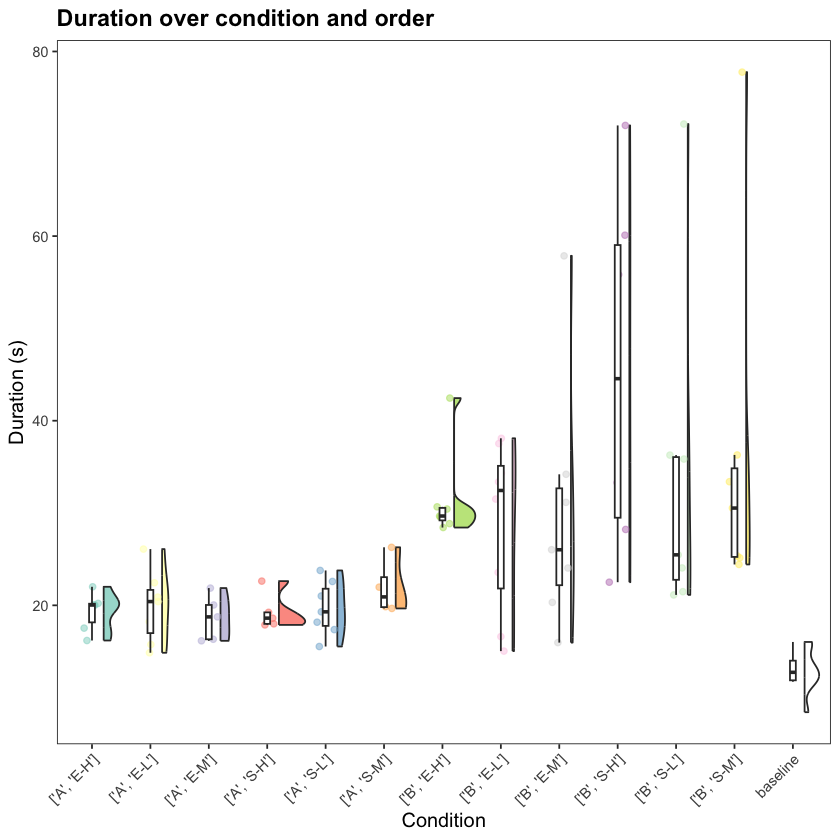

In [ ]:
# raincloud plot of duration over condition without ourliers

dur <- ggplot(data_collective2, aes(x = condition, y = duration, fill = condition)) +
  geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8) +
  geom_point(aes(y = duration, color = condition), position = position_jitter(width = .15), alpha = 0.5) +
  geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
  scale_color_brewer(palette = "Set3") +
  scale_fill_brewer(palette = "Set3") +
  theme_apa() +
  theme(legend.position = "none") +
  #facet_wrap(~order) +
  labs(x = "Condition", y = "Duration (s)", title = "Duration over condition and TMT difficulty (no outliers)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

dur

Warning message in geom_boxplot(width = 0.1, guides = FALSE, outlier.shape = NA, :
“Ignoring unknown parameters: `guides`”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set3 is 12
Returning the palette you asked for with that many colors
”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set3 is 12
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


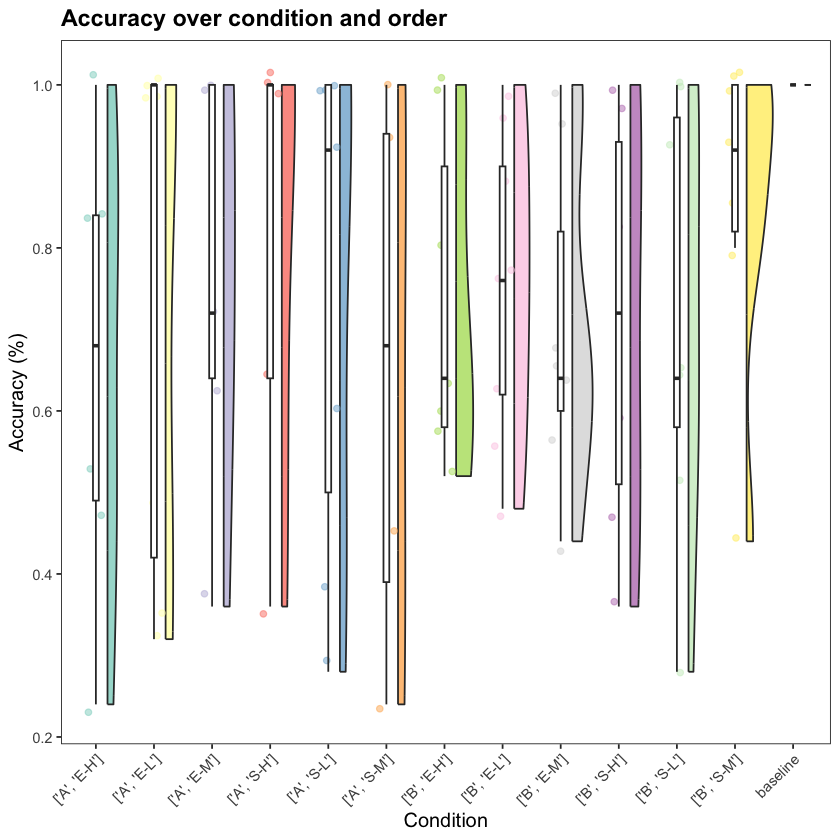

In [ ]:
# do the same about accuracy

acc <- ggplot(data_collective2, aes(x = condition, y = accuracy, fill = condition)) +
  geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8) +
  geom_point(aes(y = accuracy, color = condition), position = position_jitter(width = .15), alpha = 0.5) +
  geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, fill = "white") +
  scale_color_brewer(palette = "Set3") +
  scale_fill_brewer(palette = "Set3") +
  theme_apa() +
  theme(legend.position = "none") +
  #facet_wrap(~order) +
  labs(x = "Condition", y = "Accuracy (%)", title = "Accuracy over condition and TMT difficulty (no outliers)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

acc